In [285]:
import pandas as pd
import geopandas as gpd
import geoparquet as gpq
import graph_tool.all as gt
import seaborn as sns
import numpy as np
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from more_itertools import pairwise
from matplotlib import pyplot
sns.set()
%matplotlib inline

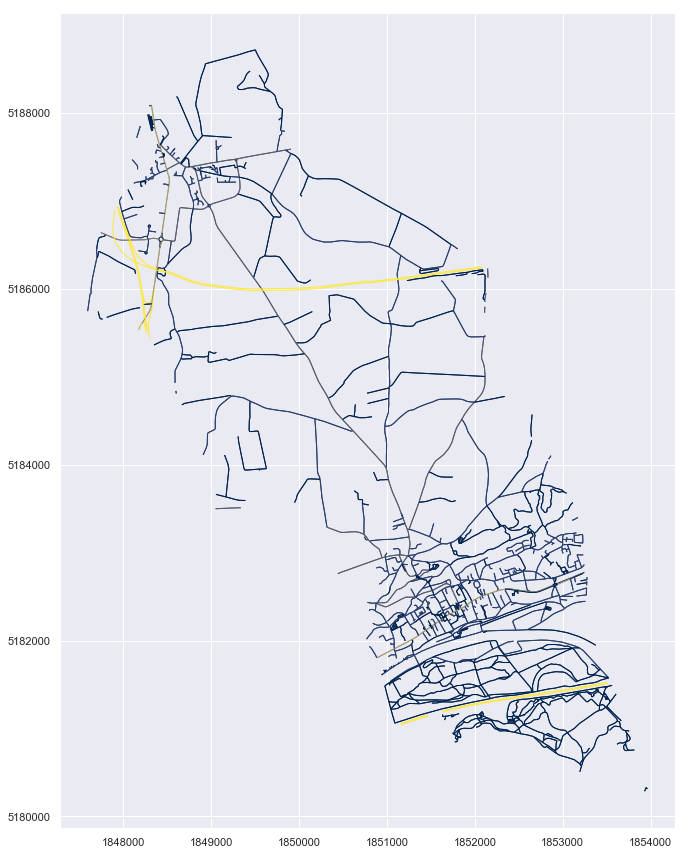

In [16]:
gdf = gpq.read_geoparquet('/Users/fabien/Dropbox/Urban Data Hackathon/France-city-network/Paris-Directed-network/01249.geoparquet')
gdf.plot(linewidth=1, column='level', cmap='cividis', figsize=(15,15))

In [303]:
xmin, ymin, xmax, ymax = 1851000,5182000 , 1852000, 5183000
gdf_downtown = gdf.cx[xmin:xmax, ymin:ymax].copy()
gdf_downtown.head(n=1)

,u,v,path,osm_id,highway,level,lanes,width,bicycle,bicycle_safety,foot,foot_safety,max_speed,motorcar,geometry
edge_id,,,,,,,,,,,,,,,
11725,1881720851,75356394,"[1881720851, 75356263, 75356262, 75356393, 753...",8681371,tertiary,4,2,6.0,1,0,1,0,50,1,"LINESTRING (1851256.584 5183049.307, 1851251.1..."


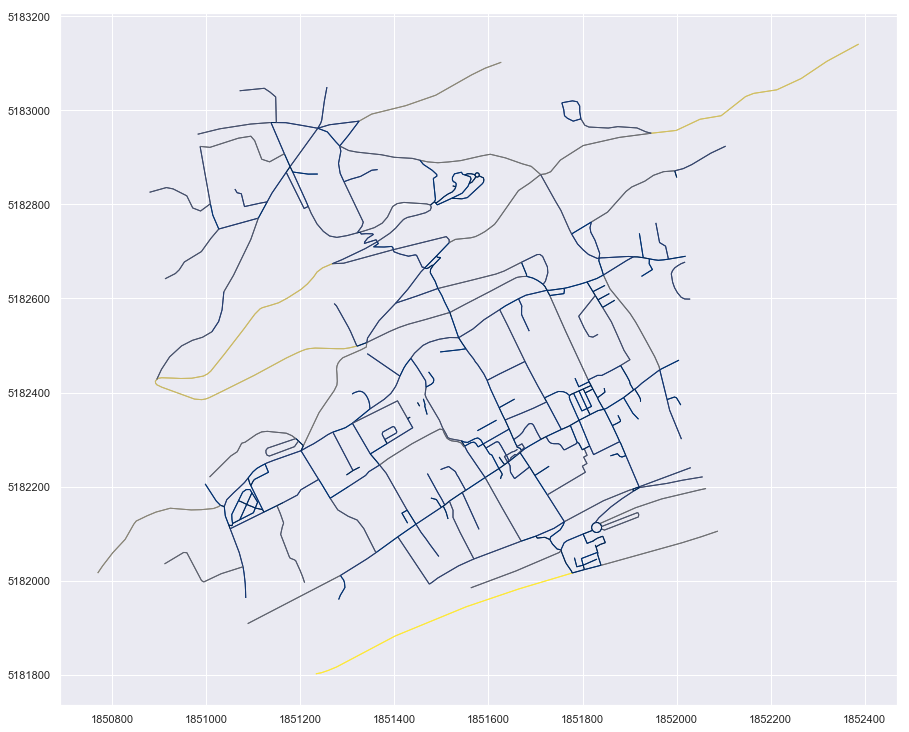

In [106]:
gdf_downtown.plot(linewidth=1, column='time', cmap='cividis', figsize=(15,15))

In [238]:
def speed(x)

gdf_downtown['time'] = gdf_downtown.geometry.length * 3600 / 3000
gdf_downtown.dropna(inplace=True)

In [241]:
g = gt.Graph(directed=True)
time = g.new_edge_property('float')
edges_id = g.new_edge_property('int')

edgelist = gdf_downtown.reset_index()[['u','v','time', 'edge_id']].values
nodes_id = g.add_edge_list(edgelist, hashed=True, eprops=[time, edges_id])

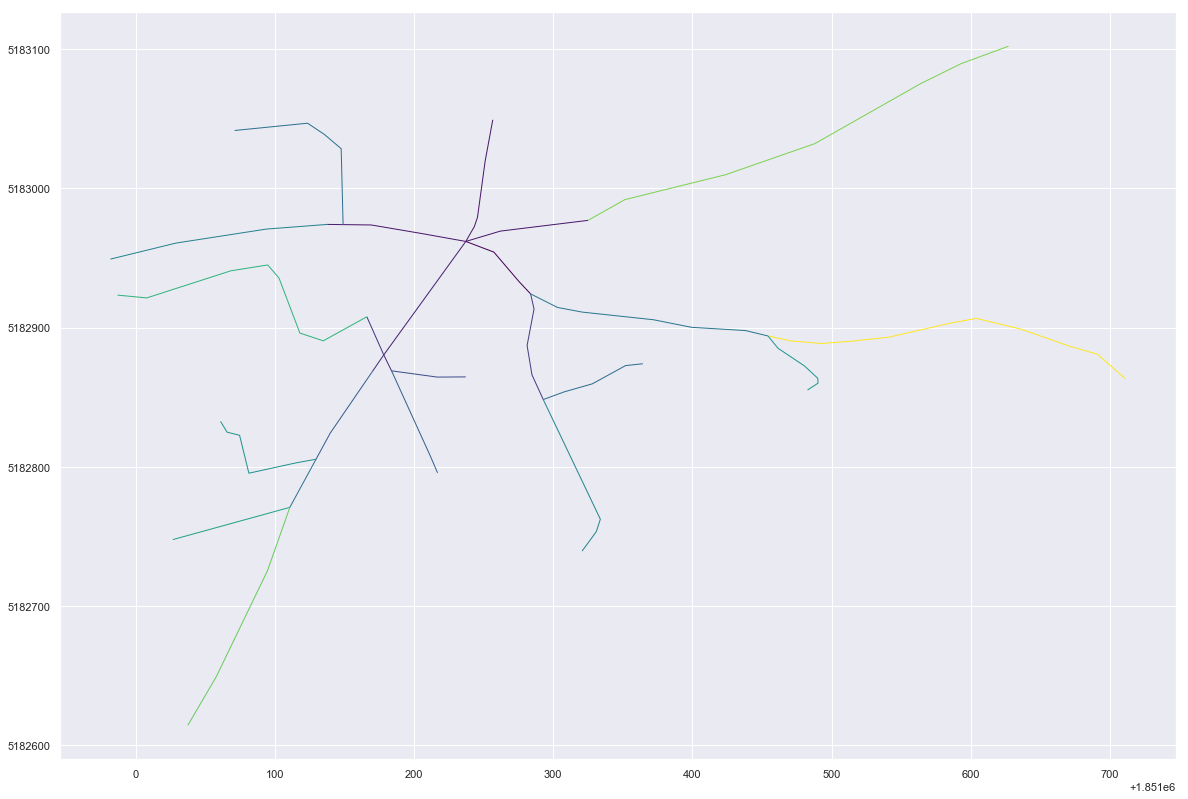

In [301]:
threshold = 300
v_colors = g.new_vertex_property('string')
v_colors.set_value('b')

class VisitorIsochrone(gt.DijkstraVisitor):
    def __init__(self, dist, thresh):
        self.dist = dist
        self.thresh = thresh

    def examine_vertex(self, u):
        if self.dist[u] > self.thresh:
            raise gt.StopSearch()

dist = g.new_vertex_property("double")
visitor = VisitorIsochrone(dist, threshold)
dist, pred =  gt.dijkstra_search(g, time, source=g.vertex(1), visitor=visitor, dist_map=dist, infinity=np.inf)

reachable = []
for i,value in enumerate(dist.a):
    #print(i, value, np.isinf(value))
    if not np.isinf(value):
        v_colors[i] = 'r'
        e = g.edge(s=pred[i], t=i)
        if e is not None:
            reachable.append((edges_id[e],dist[pred[i]], dist[i]))

gdf_downtown['isochrone_u']=np.inf
gdf_downtown['isochrone_v']=np.inf
for i,t1,t2 in reachable:
    #index = next(iter(gdf_downtown[(gdf_downtown.u==u) & (gdf_downtown.v ==v)].index), 'no match')
    gdf_downtown.at[i,'isochrone_u']=t1
    gdf_downtown.at[i,'isochrone_v']=t2
gdf_downtown[gdf_downtown.isochrone_u != np.inf].plot(linewidth=1, column='isochrone', cmap='viridis', figsize=(20,20))

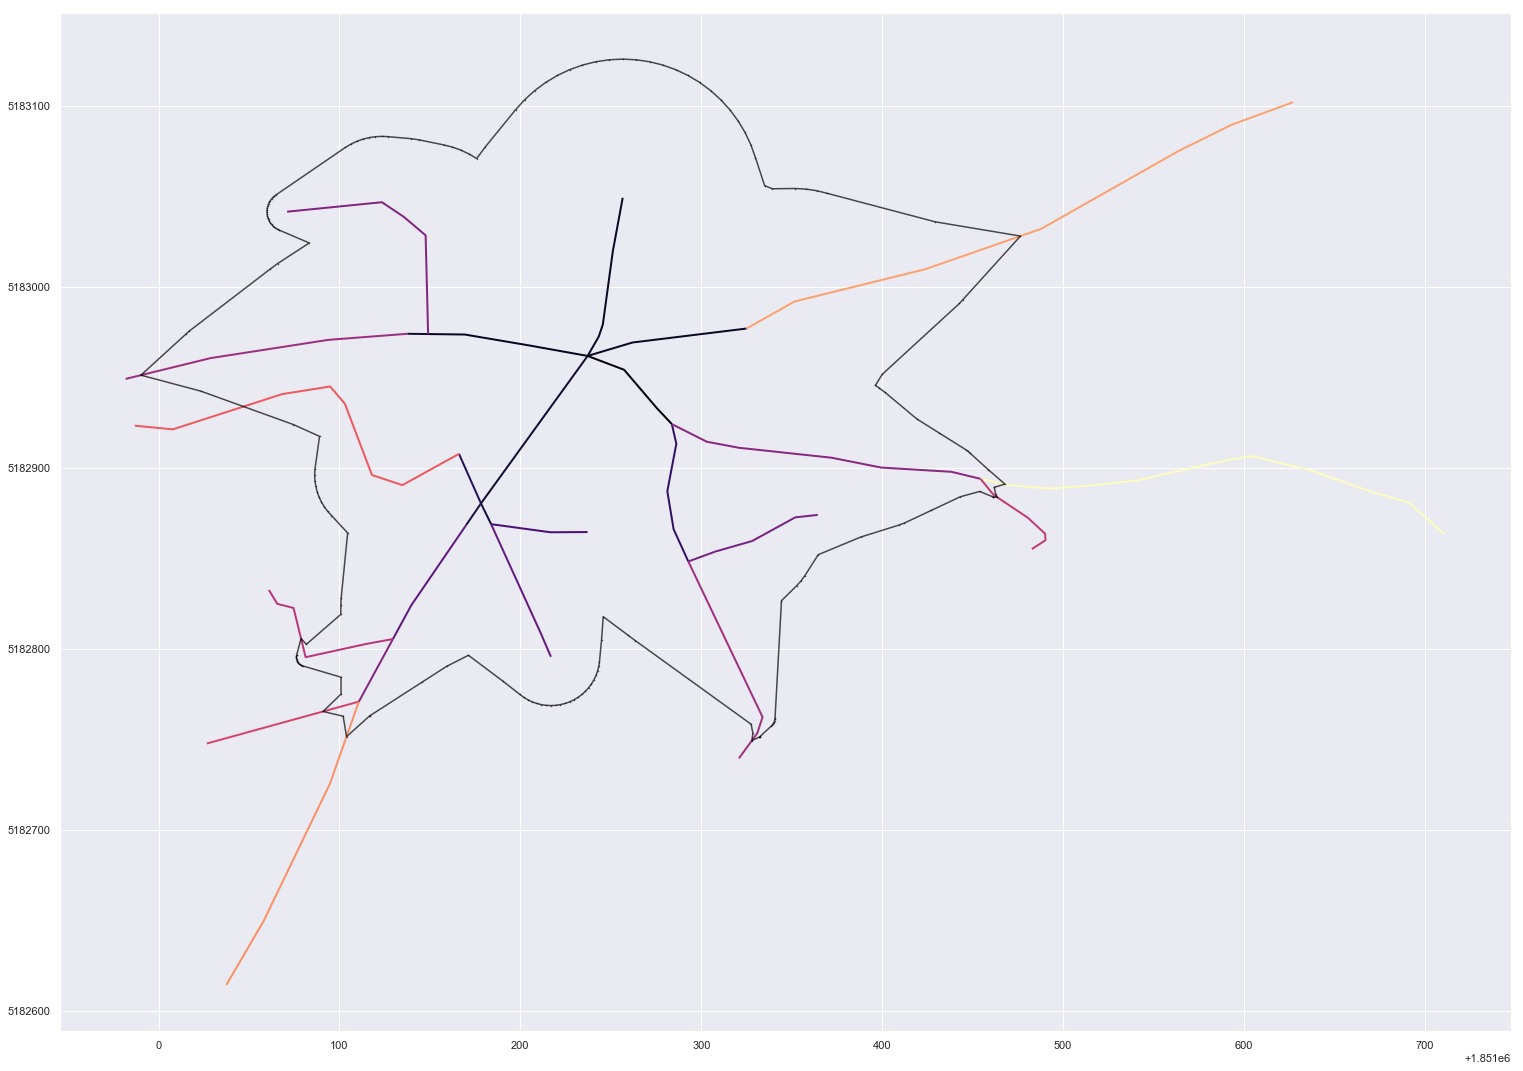

In [302]:
def cut_linestring(line: LineString, distance: float):
    r"""
    # Cuts a line in two at a distance from its starting point

    Returns
    -------
    LineString : dictionary
       Dictionary of n
    """
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

def asymmetric_segment_buffer(a: Point, b: Point, a_buffer: float, b_buffer: float) -> Polygon:
    if a_buffer > 0:
        a = a.buffer(a_buffer)
        a = np.ravel(np.array(a.exterior.coords.xy),order='F')
    else:
        a = np.ravel(np.array(a.xy),order='F')
    
    if b_buffer > 0:
        b = b.buffer(b_buffer)
        b = np.ravel(np.array(b.exterior.coords.xy),order='F')
    else:
        b = np.ravel(np.array(b.xy),order='F')
    
    h = np.concatenate((a, b), axis=None)
    h = np.reshape(h, (-1, 2))

    hull = ConvexHull(h)
    xs, ys = h[hull.vertices,0], h[hull.vertices,1]
    return Polygon(zip(xs, ys))


def asymmetric_line_buffer(line: LineString, start_value: float, stop_value: float) -> Polygon:
    if start_value == stop_value:
        return line.buffer(start_value)
    
    coords = list(line.coords)
    dists = [0] + [LineString(line.coords[:i+1]).length for i in range(1,len(coords)-1)] + [line.length]
    buffers = np.interp(dists, [0,line.length], [start_value, stop_value])
    
    polygons = []
    for i in range(len(coords)-1):
        polygons.append(asymmetric_segment_buffer(Point(coords[i]), Point(coords[i+1]), buffers[i], buffers[i+1]))
    return unary_union(polygons)
        
isochrone_polygon = []
speed = 0.4

for i,r in gdf_downtown[gdf_downtown.isochrone_u != np.inf].iterrows():
    time_left_u = threshold - r['isochrone_u']
    time_left_v = threshold - r['isochrone_v']
    line_length = r['geometry'].length
    
    if time_left_v < 0:
        stop = time_left_u * line_length / (time_left_u - time_left_v)
        line = cut_linestring(r['geometry'],stop)[0]
        time_left_v = 0
        line_length = line.length
    else:
        line = r['geometry']
    
    isochrone_polygon.append(asymmetric_line_buffer(line, time_left_u * speed, time_left_v * speed))

isochrone_polygon = unary_union(isochrone_polygon)
                            
fig, ax = pyplot.subplots(figsize=(26, 20))
gdf_downtown[gdf_downtown.isochrone_u != np.inf].plot(ax=ax,linewidth=2, column='isochrone', cmap='magma', figsize=(15,15))
ax.plot(*isochrone_polygon.exterior.xy, marker='o',color='black',alpha=0.7,markersize=0.5)


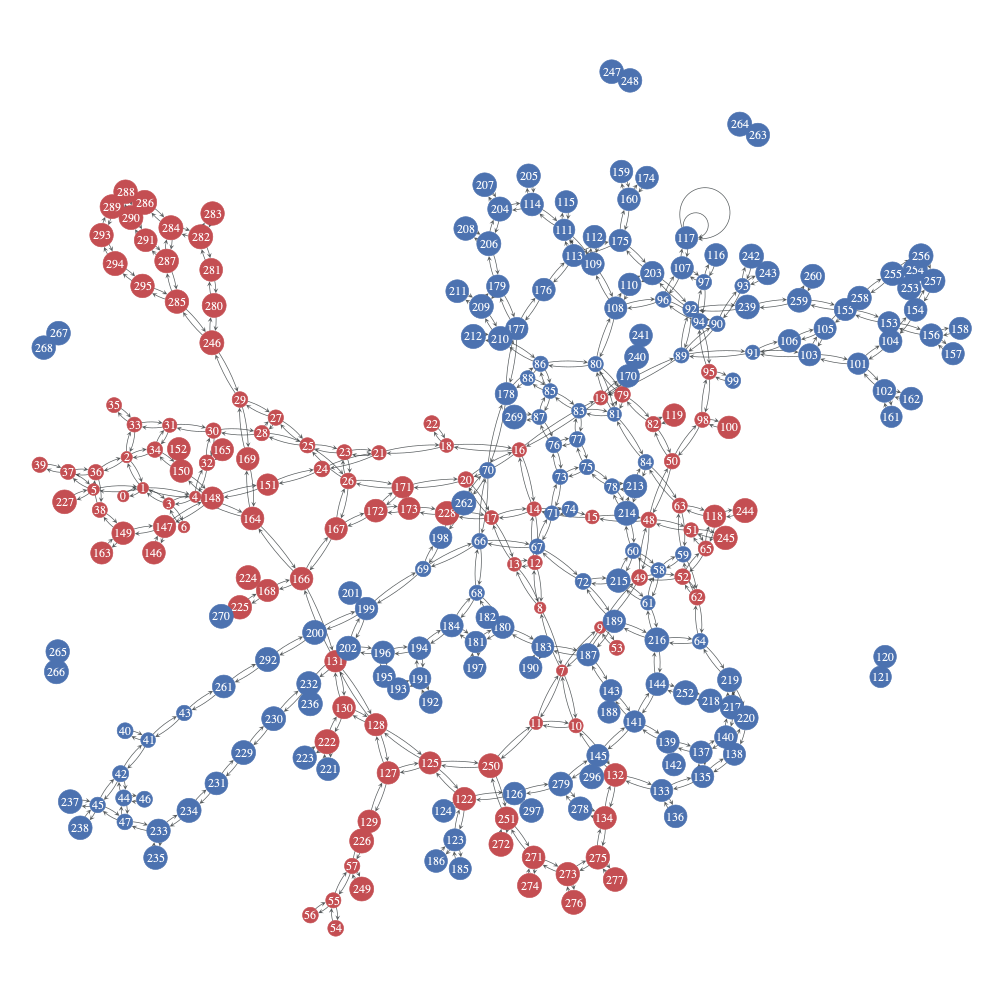

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1650ff590, at 0x135af4850>

In [196]:
gt.graph_draw(g,vertex_size=6, vertex_text=v_prop, vertex_color=v_colors, vertex_fill_color=dist, edge_pen_width=0.7, edge_marker_size=5, output_size=(1000, 1000), inline=True)

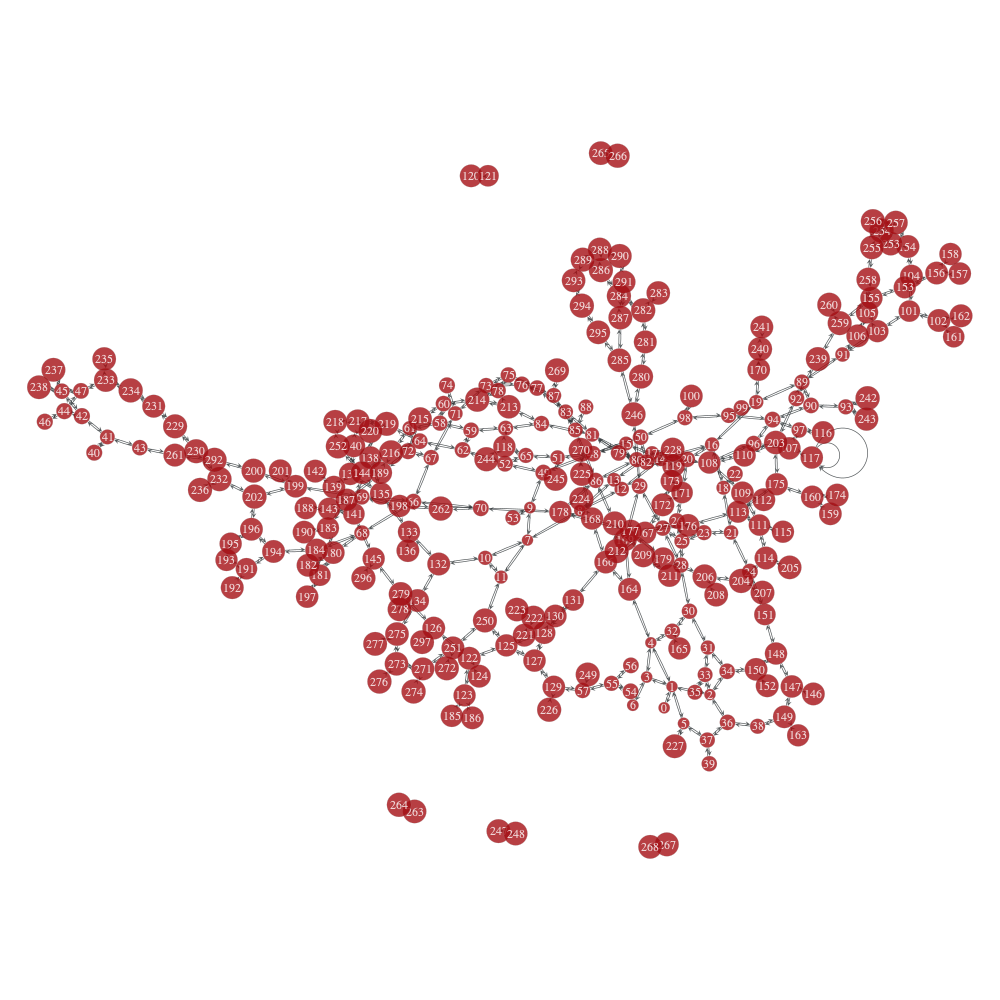

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1650ff590, at 0x165139950>

In [149]:
v_prop = g.new_vertex_property('string')
for v in g.get_vertices():
    v_prop[v] = str(v)
gt.graph_draw(g,vertex_size=2, vertex_text=v_prop, edge_pen_width=0.7, edge_marker_size=5, output_size=(1000, 1000), inline=True)
#gt.graph_draw(g,vertex_size=2,edge_pen_width=0.7, edge_marker_size=5, output_size=(1000, 1000), inline=True)

In [138]:
d = g.degree_property_map('total')
list(d.a).index(10)
nodes_id[1]

75356394.0

In [139]:
gdf_downtown.loc[gdf_downtown.u == 75356394]

,u,v,path,osm_id,highway,level,lanes,width,bicycle,bicycle_safety,foot,foot_safety,max_speed,motorcar,geometry,time
edge_id,,,,,,,,,,,,,,,,
3997,75356394,567059198,"[75356394, 567059198]",44683713,tertiary,4,2,6.0,1,0,1,0,50,1,"LINESTRING (1851237.202 5182961.885, 1851178.2...",33.535559
11726,75356394,1881720851,"[75356394, 75356393, 75356262, 75356263, 18817...",8681371,tertiary,4,2,6.0,1,0,1,0,50,1,"LINESTRING (1851237.202 5182961.885, 1851243.3...",30.101931
11900,75356394,567059230,"[75356394, 567059302, 567059230]",9645366,residential,3,2,6.0,1,1,1,1,-1,1,"LINESTRING (1851237.202 5182961.885, 1851261.9...",29.785982
12274,75356394,567059232,"[75356394, 567059260, 567059259, 567059232]",44683715,residential,3,2,6.0,1,1,1,1,-1,1,"LINESTRING (1851237.202 5182961.885, 1851257.3...",20.514606
13005,75356394,673701460,"[75356394, 74952543, 671430032, 673701460]",218731193,tertiary,4,2,6.0,1,0,1,0,50,1,"LINESTRING (1851237.202 5182961.885, 1851205.1...",29.737411


POINT (0 0) POINT (30 0)


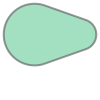

In [91]:
l = LineString([(0.0, 0.0), (30.0, 0.0)])
a,b = [shapely.geometry.Point(i) for i in l.coords]
print(a,b)
p = a.buffer(20)
q = b.buffer(10)

p = np.ravel(np.array(p.exterior.coords.xy),order='F')
q = np.ravel(np.array(q.exterior.coords.xy),order='F')
h = np.concatenate((p, q), axis=None)
h = np.reshape(h, (-1, 2))

hull = ConvexHull(h)
xs, ys = h[hull.vertices,0], h[hull.vertices,1]
polygon = shapely.geometry.Polygon(zip(xs, ys))
polygon

In [85]:
import matplotlib.pyplot as plt
plt.plot(h[:,0], h[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(h[simplex, 0], h[simplex, 1], 'k-')

TypeError: 'ConvexHull' object is not subscriptable

array([[ 3.00000000e+00,  2.98555418e+00,  2.94235584e+00,
         2.87082101e+00,  2.77163860e+00,  2.64576379e+00,
         2.49440884e+00,  2.31903136e+00,  2.12132034e+00,
         1.90317985e+00,  1.66671070e+00,  1.41419021e+00,
         1.14805030e+00,  8.70854032e-01,  5.85270966e-01,
         2.94051421e-01,  4.84663372e-15, -2.94051421e-01,
        -5.85270966e-01, -8.70854032e-01, -1.14805030e+00,
        -1.41419021e+00, -1.66671070e+00, -1.90317985e+00,
        -2.12132034e+00, -2.31903136e+00, -2.49440884e+00,
        -2.64576379e+00, -2.77163860e+00, -2.87082101e+00,
        -2.94235584e+00, -2.98555418e+00, -3.00000000e+00,
        -2.98555418e+00, -2.94235584e+00, -2.87082101e+00,
        -2.77163860e+00, -2.64576379e+00, -2.49440884e+00,
        -2.31903136e+00, -2.12132034e+00, -1.90317985e+00,
        -1.66671070e+00, -1.41419021e+00, -1.14805030e+00,
        -8.70854032e-01, -5.85270966e-01, -2.94051421e-01,
        -8.54469684e-15,  2.94051421e-01,  5.85270966e-0